**End-to-End Convolutional Neural Network for Fashion-MNIST Classification Using PyTorch**

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cpu


**Data Preprocessing**

In [21]:
# transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])


In [22]:
# load dataset
train_dataset = datasets.FashionMNIST(
    root="./data",
    train = True,
    download = True,
    transform = transform
)

test_dataset = datasets.FashionMNIST(
    root = "./data",
    train  = False,
    download = True,
    transform = transform
)

In [23]:
# dataloader
train_loader = DataLoader(train_dataset,batch_size = 64,shuffle=True)
test_loader  = DataLoader(test_dataset,batch_size = 64,shuffle=True)

**CNN MODEL**

In [24]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN,self).__init__()

    self.conv1 = nn.Conv2d(1,16,kernel_size=3,padding = 1)
    self.conv2 = nn.Conv2d(16,32,kernel_size = 3,padding = 1)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(32*7*7,128)
    self.fc2 = nn.Linear(128,10)

  def forward(self,x):
    x = self.pool(torch.relu(self.conv1(x)))
    x = self.pool(torch.relu(self.conv2(x)))
    x = x.view(x.size(0),-1)
    x = torch.relu(self.fc1(x))
    return self.fc2(x)

**INITIALISE MODEL, LOSS, OPTIMIZER**

In [25]:
model  = FashionCNN().to(device)

loss_fn = nn.CrossEntropyLoss()   #for multiclass classification
optimizer= optim.Adam(model.parameters(),lr = 0.001)

In [26]:
# training loop
epochs = 10
for epoch in range(epochs):
  model.train()
  cur_loss = 0.0

  for images,labels in train_loader:
    images,labels = images.to(device),labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()

    cur_loss += loss.item()

  print(f"Epoch {epoch+1}/{epochs}, Loss: {cur_loss/len(train_loader)}")


Epoch 1/10, Loss: 0.4655439018218248
Epoch 2/10, Loss: 0.30940481347601806
Epoch 3/10, Loss: 0.2636901529581308
Epoch 4/10, Loss: 0.23494344472345005
Epoch 5/10, Loss: 0.21136519074169938
Epoch 6/10, Loss: 0.193783866837303
Epoch 7/10, Loss: 0.17280036821834313
Epoch 8/10, Loss: 0.15758614501020293
Epoch 9/10, Loss: 0.14391805474429942
Epoch 10/10, Loss: 0.13009056944582761


In [27]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for images,labels in test_loader:
    images,labels  = images.to(device),labels.to(device)
    outputs = model(images)
    _,predicted = torch.max(outputs,1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
accuracy = 100 *correct / total
print(f"Test accuracy: {accuracy:2f}%")

Test accuracy: 91.610000%


**SAVE**

In [28]:
torch.save(model.state_dict(),'Fashion_cnn.pt')

**LOAD**

In [29]:
model = FashionCNN().to(device)
model.load_state_dict(torch.load("Fashion_cnn.pt"))
model.eval()

FashionCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

**Single Image Prediction**

In [30]:
classes = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

image, label = test_dataset[0]
image = image.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image)
    pred = output.argmax(dim=1)

print("Predicted:", classes[pred.item()])
print("Actual   :", classes[label])


Predicted: Ankle boot
Actual   : Ankle boot


**VISUALIZATION**

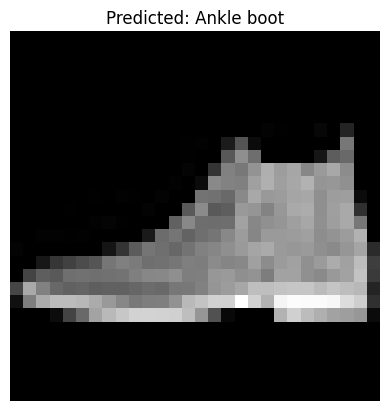

In [31]:
plt.imshow(image.cpu().squeeze(), cmap="gray")
plt.title(f"Predicted: {classes[pred.item()]}")
plt.axis("off")
plt.show()
